<a href="https://colab.research.google.com/github/paaulnl/ObjectDeteccionIA/blob/main/IA_ETAPA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained("nickmuchi/yolos-small-finetuned-license-plate-detection")
model = AutoModelForObjectDetection.from_pretrained("nickmuchi/yolos-small-finetuned-license-plate-detection")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/123M [00:00<?, ?B/s]

In [ ]:
!pip install transformers
!pip install torch torchvision
!pip install pillow


In [ ]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image, ImageDraw
import torch
import requests
from io import BytesIO

In [ ]:
# Cargar modelo finetuneado en placas
model = YolosForObjectDetection.from_pretrained("nickmuchi/yolos-small-finetuned-license-plate-detection")
processor = YolosImageProcessor.from_pretrained("nickmuchi/yolos-small-finetuned-license-plate-detection")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Saving images (1).jpeg to images (1).jpeg


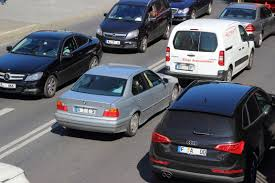

In [ ]:
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert("RGB")
image

In [ ]:

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

logits = outputs.logits
boxes = outputs.pred_boxes

probas = logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.5

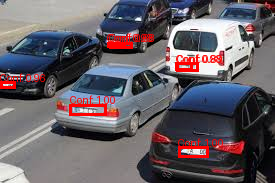

In [ ]:
from IPython.display import display

draw = ImageDraw.Draw(image)
w, h = image.size

if keep.sum() == 0:
    print("No se detectaron placas en la imagen.")
else:
    for score, box in zip(probas[keep], boxes[0][keep]):
        box = box.detach().numpy()
        box = [box[0]*w, box[1]*h, box[2]*w, box[3]*h]
        x0 = box[0] - box[2]/2
        y0 = box[1] - box[3]/2
        x1 = box[0] + box[2]/2
        y1 = box[1] + box[3]/2
        draw.rectangle([x0, y0, x1, y1], outline="red", width=3)
        draw.text((x0, y0 - 10), f"Conf: {score.max():.2f}", fill="red")

    # Mostrar la imagen final
    display(image)


In [ ]:
import gradio as gr
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image, ImageDraw
import torch

# Cargar modelo desde Hugging Face
model = YolosForObjectDetection.from_pretrained("nickmuchi/yolos-small-finetuned-license-plate-detection")
processor = YolosImageProcessor.from_pretrained("nickmuchi/yolos-small-finetuned-license-plate-detection")

# Función para detección
def detectar_placa(image):
    image = image.convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    logits = outputs.logits
    boxes = outputs.pred_boxes
    probas = logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.5

    draw = ImageDraw.Draw(image)
    w, h = image.size

    if keep.sum() == 0:
        return image

    for score, box in zip(probas[keep], boxes[0][keep]):
        box = box.detach().numpy()
        x0 = box[0] - box[2]/2
        y0 = box[1] - box[3]/2
        x1 = box[0] + box[2]/2
        y1 = box[1] + box[3]/2

        x0 *= w
        x1 *= w
        y0 *= h
        y1 *= h

        draw.rectangle([x0, y0, x1, y1], outline="red", width=3)
        draw.text((x0, y0 - 10), f"Conf: {score.max():.2f}", fill="red")

    return image

# Crear la interfaz Gradio
demo = gr.Interface(
    fn=detectar_placa,
    inputs=gr.Image(type="pil"),
    outputs="image",
    title="Detección de Placas Vehiculares",
    description="Sube una imagen de un vehículo y detectaremos la ubicación de la placa automáticamente."
)

# Ejecutar
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3ed79970e10ec1a9ac.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
